<a href="https://colab.research.google.com/github/sftSalman/neural_style_transformation/blob/main/Image_transformation_using__neural_style.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This note book will be used for image transformation using neural style transformation  . Transfer learning will be used here  which was previsely trained by vgg19 network using Imagenet dataset 
```



In [15]:
#@title nst_utils

import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image

import numpy as np
import tensorflow as tf

class CONFIG:
    IMAGE_WIDTH = 400
    IMAGE_HEIGHT = 300
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.6
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    VGG_MODEL = 'pretrained-model/imagenet-vgg-verydeep-19.mat' # Pick the VGG 19-layer model by from the paper "Very Deep Convolutional Networks for Large-Scale Image Recognition".
    STYLE_IMAGE = 'images/stone_style.jpg' # Style image to use.
    CONTENT_IMAGE = 'images/content300.jpg' # Content image to use.
    OUTPUT_DIR = 'output/'
    
def load_vgg_model(path):
    """
    Returns a model for the purpose of 'painting' the picture.
    Takes only the convolution layer weights and wrap using the TensorFlow
    Conv2d, Relu and AveragePooling layer. VGG actually uses maxpool but
    the paper indicates that using AveragePooling yields better results.
    The last few fully connected layers are not used.
    Here is the detailed configuration of the VGG model:
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu    
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """
    
    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']
    
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b

        return W, b

    def _relu(conv2d_layer):
        """
        Return the RELU function wrapped over a TensorFlow layer. Expects a
        Conv2d layer input.
        """
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        """
        Return the AveragePooling layer.
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph

def generate_noise_image(content_image, noise_ratio = CONFIG.NOISE_RATIO):
    """
    Generates a noisy image by adding random noise to the content_image
    """
    
    # Generate a random noise_image
    noise_image = np.random.uniform(-20, 20, (1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)).astype('float32')
    
    # Set the input_image to be a weighted average of the content_image and a noise_image
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    
    return input_image


def reshape_and_normalize_image(image):
    """
    Reshape and normalize the input image (content or style)
    """
    
    # Reshape image to mach expected input of VGG16
    image = np.reshape(image, ((1,) + image.shape))
    
    # Substract the mean to match the expected input of VGG16
    image = image - CONFIG.MEANS
    
    return image


def save_image(path, image):
    
    # Un-normalize the image so that it looks good
    image = image + CONFIG.MEANS
    
    # Clip and Save the image
    image = np.clip(image[0], 0, 255).astype('uint8')
    scipy.misc.imsave(path, image)

Required Packages


In [16]:
# import packages
import os 
import sys 
import scipy.io 
import scipy.misc
import matplotlib.pyplot as plt
from PIL import Image 
import numpy as np 
import tensorflow as tf
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
import pprint
%matplotlib inline

Downloading the pretrained vgg model 


In [17]:
tf.random.set_seed(100)
img_size = 420
vgg_model = tf.keras.applications.VGG19(include_top=False,
                                        weights='imagenet',
                                        input_shape=(img_size,img_size,3))

vgg_model.trainble = False


In [18]:
print(vgg_model)

In [19]:
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 420, 420, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 420, 420, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 420, 420, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 210, 210, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 210, 210, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 210, 210, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 105, 105, 128)     0     

# Content image


In [36]:
content_img = Image.open('/content/drive/MyDrive/Deep Learning/tensorFlow/image_transformation/bc2.jpg')

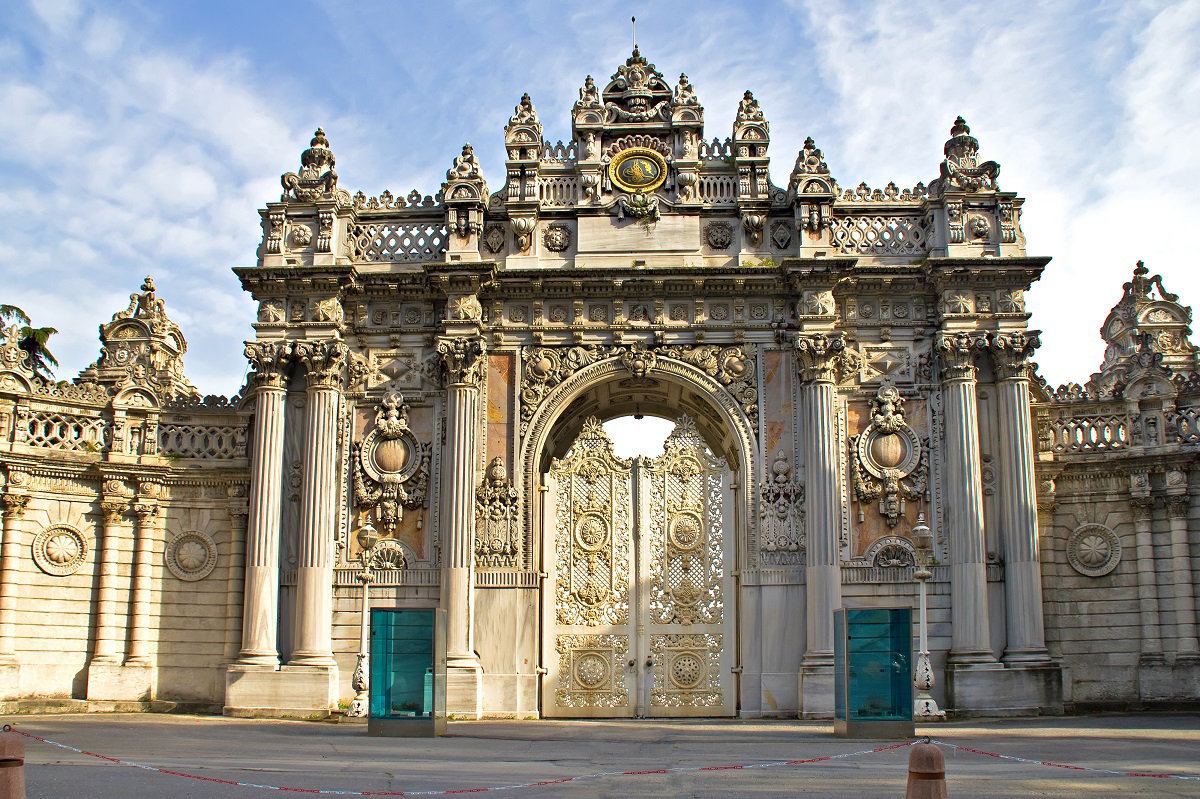

In [37]:
content_img

#Style Image

In [38]:
style_img = Image.open('/content/drive/MyDrive/Deep Learning/tensorFlow/image_transformation/bs1.jpg')

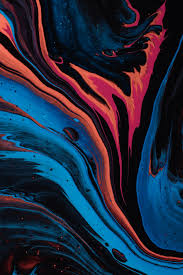

In [39]:
style_img

# Content loss : 
$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

In [40]:
def content_cost(content_output, gen_output):
  a_C = content_output[-1]
  a_G = gen_output[-1]

  m,n_H,n_W,n_C = a_G.get_shape().as_list()

  a_C_unroll = tf.reshape(a_C,shape[m,n_H*n_W,n_C])
  a_G_unroll = tf.reshape(a_G,shape[m,n_H*n_W,n_C])
  
  J_content= tf.reduce_sum(tf.square(a_C_unroll - a_G_unroll)/(4.0*n_H*n_W*n_C))

  return J_content

In [58]:
for layer in vgg_model.layers:
    print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [60]:
vgg_model.get_layer('block5_conv4').output

<KerasTensor: shape=(None, 26, 26, 512) dtype=float32 (created by layer 'block5_conv4')>

In [63]:
STYLE_LAYERS = [
    ('block1_conv1', 1.0),
    ('block2_conv1', 0.8),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.1)]

# Style loss : 
$$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$

Where gram matrix is:
${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. 


$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$


In [64]:
def gram(A):
  GA  = tf.matmul(A,tf.transpose(A))
  return GA

In [77]:
def style_cost(a_S,a_G):
  m,n_H,n_W,n_C = a_G.get_shape().as_list()

  a_S = tf.tranpose(tf.reshape(a_S,shape[m,n_H*n_W,n_C]))
  a_G = tf.transpose(tf.reshape(a_G,shape[m,n_H*n_W,n_C]))

  GS = gram(a_S)
  GC = gram(a_G)

  J_style_layer = tf.reduce_sum(tf.square(GS - GG))/(4.0 *(( n_H * n_W * n_C)**2))

  return J_style_layer


In [78]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The first element of the array contains the input layer image, which must not to be used.
    a_S = style_image_output[1:]

    # Set a_G to be the output of the choosen hidden layers.
    # The First element of the list contains the input layer image which must not to be used.
    a_G = generated_image_output[1:]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

# Total cost function:
$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

In [66]:
def total_cost(J_content,J_style, alpha=9, beta =50): # just a bit more impression given to style image

  J = alpha*J_content + beta*J_style

  return J

# Loading Content image and Style image and then preposess for the model 

In [67]:
# content_img = np.array(content_img.resize(img_size*img_size)))
# content_img = tf.constant(np.reshape(content_img,(1,),content_img.shape))
content_image = np.array(content_img.resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

(1, 420, 420, 3)


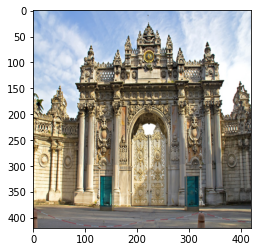

In [68]:
print(content_image.shape)
imshow(content_image[0])
plt.show()

(1, 420, 420, 3)


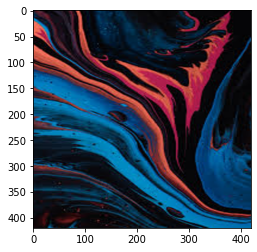

In [69]:
style_image =  np.array(style_img.resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

# Random initialization for genereting new image 

In [70]:
# #gen_img = tf.Variable(tf.image.convert_image_dtype(content_img,tf.float32))
# gen_img = tf.Variable(tf.image.convert_image_dtype(content_img, tf.float32))
# noise = tf.random.uniform(tf.shape(gen_img),0,0.6) # min val = 0 , max val =.6


# gen_img = tf.add(gen_img,noise)
# gen_img = tf.clip_by_value(gen_img,clip_value_min=0.0, clip_value_max=1.0)  # clip_by_value()  is used to clip a Tensor values to a specified min and max.

(1, 420, 420, 3)


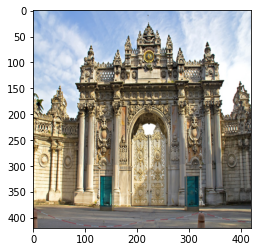

In [71]:
content_image = np.array(Image.open("/content/drive/MyDrive/Deep Learning/tensorFlow/image_transformation/bc2.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

(1, 420, 420, 3)


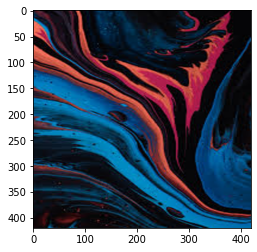

In [72]:
style_image =  np.array(Image.open("/content/drive/MyDrive/Deep Learning/tensorFlow/image_transformation/bs1.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

(1, 420, 420, 3)


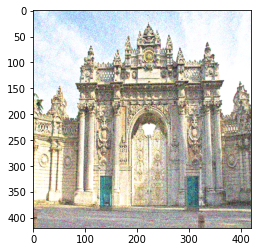

In [73]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), 0, 0.4)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

(1, 420, 420, 3)


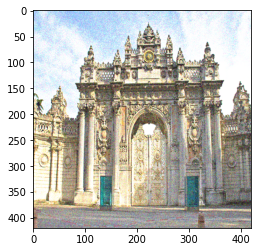

In [74]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), 0, 0.3)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

Avobe random value from 0.0 to o.3 shows perfect for this images , thats why I keep it 

# Loading vgg model for output layers

In [75]:
def get_layer_outputs(vgg_model, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # layer_names has 'layer' elements in it.
    outputs = [vgg_model.get_layer(layer[0]).output for layer in layer_names] # layer[0] = number of layer

    model = tf.keras.Model([vgg_model.input], outputs)
    return model

#Showing VGG19 layers 

In [76]:
# summarize filter shapes
for layer in vgg_model.layers:
    # check for convolutional layer
    print(layer.name)
    if 'conv' not in layer.name:
        continue

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
